In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
from tensorflow.python.module.module import valid_identifier
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 4ms/step - loss: 0.3372 - val_loss: 0.3135
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3064 - val_loss: 0.3027
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2997 - val_loss: 0.2983
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2959 - val_loss: 0.2956
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2934 - val_loss: 0.3010
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2916 - val_loss: 0.2919
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2903 - val_loss: 0.2932
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2891 - val_loss: 0.2899
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2881 - val_loss: 0.2890
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.28

In [11]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

def show_reconstructions(model, n_images=5):
  reconstructions = model.predict(X_valid[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(X_valid[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 18ms/step


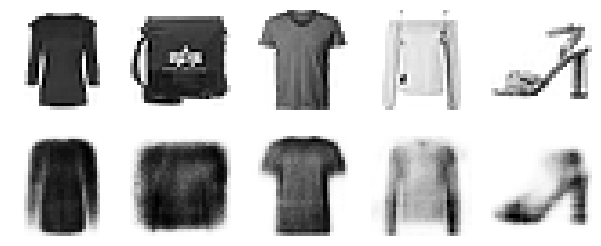

In [12]:
show_reconstructions(stacked_ae)

In [13]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


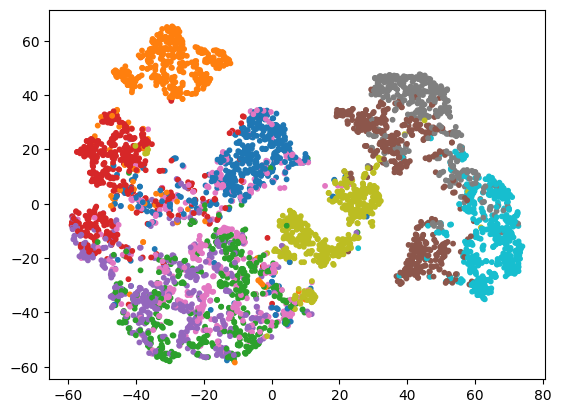

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")

In [15]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",
                                  shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)

  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [16]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])